In [ ]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 761.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 28.1 MB/s eta 0:00:00


In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (4,895 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [ ]:
import numpy as np
import pandas as pd
import requests
import concurrent.futures
import re
import torch
import timm
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import StandardScaler
import time
import copy
from collections import defaultdict
import gc
from io import BytesIO
import pickle
from transformers import BertTokenizer, BertModel
import pytesseract
device = 'cuda' if torch.cuda.is_available() else 'cpu'

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
train = pd.read_csv('/content/behaviour_simulation_train.csv')

In [ ]:
# Helper function to extract preview links using regex
def extract_preview_link(media_str):
    # Extracting links based on media type (Gif, Photo, Video)
    gif_match = re.search(r"Gif\(thumbnailUrl='(.*?)'", media_str)
    photo_match = re.search(r"Photo\(previewUrl='(.*?)'", media_str)
    video_match = re.search(r"Video\(thumbnailUrl='(.*?)'", media_str)

    if gif_match:
        return gif_match.group(1)  # Return gif thumbnail URL
    elif photo_match:
        return photo_match.group(1)  # Return photo preview URL
    elif video_match:
        return video_match.group(1)  # Return video thumbnail URL
    else:
        return None  # Return None if no match found
train.loc[:, 'preview_link'] = train['media'].apply(extract_preview_link)

In [ ]:
def get_placeholder_image(size=(224, 224), color=(255, 255, 255)):
    return np.array(Image.new("RGB", size, color))
default_image = get_placeholder_image()

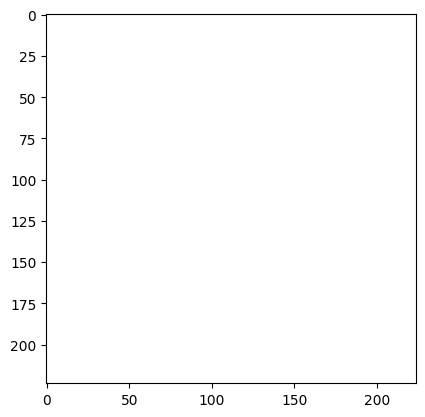

In [ ]:
plt.imshow(default_image)

In [ ]:
class Adobe_Dataset_train(Dataset):
    def __init__(self, train, default_im, transform=None, bert_model=None, tokenizer=None):
        self.train = train
        self.default_image = default_im
        self.transform = transform
        self.bert_model = bert_model
        self.tokenizer = tokenizer

    def __len__(self):
        return self.train.shape[0]

    def get_image_from_url(self, url):
        try:
            response = requests.get(url, timeout=5)
            if response.status_code == 200:
                img = np.array(Image.open(BytesIO(response.content)).convert('RGB'))
                return img
            else:
                return self.default_image
        except requests.RequestException:
            return self.default_image

    def extract_ocr_text(self, img):
        return pytesseract.image_to_string(img)

    def get_bert_embedding(self, text):
        inputs = self.tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding=True).to(device)
        with torch.no_grad():
            outputs = self.bert_model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).squeeze().detach().cpu()  # 768    -dimensional embeddings

    def __getitem__(self, idx):
        img = self.get_image_from_url(self.train['preview_link'][idx])
        target = self.train['likes'][idx]

        ocr_text = self.extract_ocr_text(img)
        metadata_text = self.train['content'][idx]

        ocr_embedding = self.get_bert_embedding(ocr_text)
        metadata_embedding = self.get_bert_embedding(metadata_text)

        if self.transform:
            img = self.transform(image=img)['image']

        return [img, ocr_embedding, metadata_embedding, target]

class Adobe_Dataset_val(Adobe_Dataset_train):
    def __init__(self, val, default_im, transform=None, bert_model=None, tokenizer=None):
        super().__init__(val, default_im, transform, bert_model, tokenizer)

In [ ]:
# class Adobe_Dataset_train(Dataset):
#     def __init__(self,train,default_im,transform=None):
#         self.train = train
#         self.default_image = default_im
#         self.transform = transform
#     def __len__(self):
#         return self.train.shape[0]
#     def get_image_from_url(self, url):
#         try:
#             response = requests.get(url, timeout=5)
#             if response.status_code == 200:
#                 img = np.array(Image.open(BytesIO(response.content)).convert('RGB'))
#                 return img
#             else:
#                 return self.default_image
#         except requests.RequestException:
#             return self.default_image
#     def __getitem__(self,idx):
#         img = self.get_image_from_url(self.train['preview_link'][idx])
#         target = self.train['likes'][idx]
#         if self.transform:
#             img = self.transform(image=img)['image']
#         return [img,target]

In [ ]:
# class Adobe_Dataset_val(Dataset):
#     def __init__(self,val,default_im,transform=None):
#         self.val = val
#         self.default_image = default_im
#         self.transform = transform
#     def __len__(self):
#         return self.val.shape[0]
#     def get_image_from_url(self, url):
#         try:
#             response = requests.get(url, timeout=5)
#             if response.status_code == 200:
#                 img = np.array(Image.open(BytesIO(response.content)).convert('RGB'))
#                 return img
#             else:
#                 return self.default_image
#         except requests.RequestException:
#             return self.default_image
#     def __getitem__(self,idx):
#         img = self.get_image_from_url(self.val['preview_link'][idx])
#         target = self.val['likes'][idx]
#         if self.transform:
#             img = self.transform(image=img)['image']
#         return [img,target]

In [ ]:
# scaler = StandardScaler()
# y=np.array(train['likes'])
# train['likes']=scaler.fit_transform(y.reshape(-1,1))
eps = 5
train['likes']=np.log(train['likes']+eps)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
transform = A.Compose([
    A.Resize(height=224, width=224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])
train_set = train[:2000]
val_set = train[2000:3000].reset_index()
# train_dataset = Adobe_Dataset_train(train_set,default_im,transform)
# val_dataset = Adobe_Dataset_val(val_set,default_im,transform)
# train_loader = DataLoader(train_dataset, batch_size = 64)
# val_loader = DataLoader(val_dataset, batch_size = 32)

In [ ]:
train_dataset = Adobe_Dataset_train(train_set, default_image, transform=transform, bert_model=bert_model, tokenizer=tokenizer)
val_dataset = Adobe_Dataset_val(val_set, default_image, transform=transform, bert_model=bert_model, tokenizer=tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False,num_workers=0)

(<matplotlib.image.AxesImage at 0x7a054d69e9b0>,
 tensor([1.6094, 4.1744, 1.6094, 5.5645, 6.2480, 8.3421, 6.6080, 7.9146, 1.6094,
         1.6094, 3.8918, 1.7918, 6.4085, 2.3979, 5.7104, 3.8286],
        dtype=torch.float64))

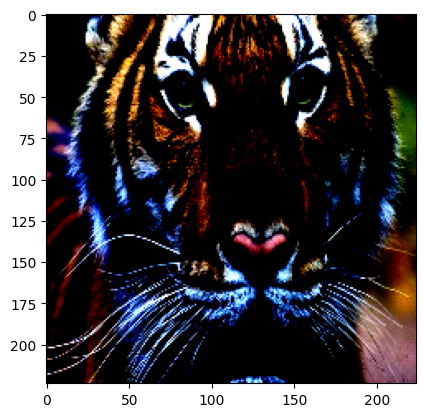

In [ ]:
l = next(iter(val_loader))
plt.imshow(l[0][2].permute(1,2,0)),l[3]

In [ ]:
def acc_metric(y_true,y_pred):
    return r2_score(y_true.detach().cpu().numpy(),y_pred.detach().cpu().numpy())

In [ ]:
# class Img_Model(nn.Module):
#     def __init__(self,out_features=1):
#         super().__init__()
#         self.model = timm.create_model('efficientnet_b0',pretrained=True)
#         in_features = self.model.classifier.in_features
#         self.model.classifier = nn.Sequential(nn.Linear(in_features,512),
#                                               nn.Linear(512,1))
#     def forward(self,x):
#         return self.model(x)
# model = Img_Model().to(device)

In [ ]:
class CombinedModel(nn.Module):
    def __init__(self, out_features=1):
        super().__init__()
        # Image model
        self.cnn_model = timm.create_model('efficientnet_b0', pretrained=True)
        in_features = self.cnn_model.classifier.in_features
        self.cnn_model.classifier = nn.Identity()  # Remove classifier for embedding extraction

        # Fully connected layers to process the combined embeddings
        self.fc1 = nn.Linear(in_features + 768*2, 512)  # 768*2 for BERT embeddings from OCR + metadata
        self.fc2 = nn.Linear(512, out_features)

    def forward(self, img, ocr_embed, metadata_embed):
        img_features = self.cnn_model(img)
        combined_features = torch.cat((img_features, ocr_embed, metadata_embed), dim=1)
        x = self.fc1(combined_features)
        x = self.fc2(x)
        return x

model = CombinedModel().to(device)
loss_fn = nn.MSELoss()
optimizer = optim.AdamW(model.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer,2)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [ ]:
# def train_one_epoch(model, optimizer, scheduler, device, dataloader, epoch):
#     model.train()
#     dataset_size = 0
#     running_loss = 0.0
#     running_mse  = 0.0
#     bar = tqdm(enumerate(dataloader), total=len(dataloader))
#     y_true = []
#     y_pred = []

#     for step, data in bar:
#         images = data[0].to(device, dtype=torch.float)
#         targets = data[1].to(device, dtype=torch.float)
#         batch_size = images.size(0)

#         optimizer.zero_grad()

#         outputs = model(images).squeeze()
#         loss = loss_fn(outputs, targets)

#         loss.backward()
#         optimizer.step()

#         running_loss += (loss.item() * batch_size)
#         running_mse += ((outputs - targets) ** 2).sum().item()

#         dataset_size += batch_size

#         epoch_loss = running_loss / dataset_size
#         epoch_mse = running_mse / dataset_size

#         y_pred.append(outputs.detach())
#         y_true.append(targets.detach())

#         bar.set_postfix(Epoch=epoch, Loss=epoch_loss, MSE=epoch_mse)

#     y_pred = torch.cat(y_pred, dim=0)
#     y_true = torch.cat(y_true, dim=0)

#     epoch_r2 = acc_metric(y_true, y_pred)

#     print(f'Epoch = {epoch}, Train_Loss = {epoch_loss}, Train_R² = {epoch_r2}, LR = {optimizer.param_groups[0]["lr"]}')

#     gc.collect()
#     torch.cuda.empty_cache()

#     return epoch_loss, epoch_r2


In [ ]:
# def valid_one_epoch(model, dataloader, device, epoch):
#     model.eval()
#     dataset_size = 0
#     running_loss = 0.0
#     running_mse = 0.0
#     with torch.inference_mode():
#         y_pred = []
#         y_true = []
#         bar = tqdm(enumerate(dataloader), total=len(dataloader))
#         for step, data in bar:
#             images = data[0].to(device, dtype=torch.float)
#             targets = data[1].to(device, dtype=torch.float)
#             batch_size = images.size(0)
#             outputs = model(images).squeeze()
#             y_pred.append(outputs)
#             y_true.append(targets)
#             loss = loss_fn(outputs, targets)
#             running_loss += (loss.item() * batch_size)
#             dataset_size += batch_size
#             epoch_loss = running_loss / dataset_size
#             epoch_mse = running_mse / dataset_size
#             del images
#             del targets
#             del batch_size
#         y_pred = torch.cat(y_pred, dim = 0)
#         y_true = torch.cat(y_true, dim = 0)
#         epoch_r2 = acc_metric(y_true,y_pred)
#         print(f'Epoch = {epoch}, Valid_Loss = {epoch_loss}, Valid_r2 = {epoch_r2}, LR = {optimizer.param_groups[0]["lr"]}')
#     torch.cuda.empty_cache()
#     gc.collect()
#     return epoch_loss, epoch_r2

In [ ]:
def train_one_epoch(model, optimizer, scheduler, device, dataloader, epoch):
    model.train()
    dataset_size = 0
    running_loss = 0.0
    running_mse  = 0.0
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    y_true = []
    y_pred = []

    for step, data in bar:
        images = data[0].to(device, dtype=torch.float)
        bert_embed_content = data[1].to(device, dtype=torch.float)
        bert_embed_ocr = data[2].to(device, dtype=torch.float)
        targets = data[3].to(device, dtype=torch.float)
        batch_size = images.size(0)

        optimizer.zero_grad()

        # Forward pass: combine image embeddings and BERT embeddings
        outputs = model(images, bert_embed_content, bert_embed_ocr).squeeze()
        loss = loss_fn(outputs, targets)

        loss.backward()
        optimizer.step()

        running_loss += (loss.item() * batch_size)
        running_mse += ((outputs - targets) ** 2).sum().item()

        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size
        epoch_mse = running_mse / dataset_size

        y_pred.append(outputs.detach())
        y_true.append(targets.detach())

        bar.set_postfix(Epoch=epoch, Loss=epoch_loss, MSE=epoch_mse)

    y_pred = torch.cat(y_pred, dim=0)
    y_true = torch.cat(y_true, dim=0)

    epoch_r2 = acc_metric(y_true, y_pred)

    print(f'Epoch = {epoch}, Train_Loss = {epoch_loss}, Train_R2 = {epoch_r2}, LR = {optimizer.param_groups[0]["lr"]}')

    gc.collect()
    torch.cuda.empty_cache()

    return epoch_loss, epoch_r2


In [ ]:
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    dataset_size = 0
    running_loss = 0.0
    running_mse = 0.0
    with torch.inference_mode():
        y_pred = []
        y_true = []
        bar = tqdm(enumerate(dataloader), total=len(dataloader))
        for step, data in bar:
            images = data[0].to(device, dtype=torch.float)
            bert_embed_content = data[1].to(device, dtype=torch.float)
            bert_embed_ocr = data[2].to(device, dtype=torch.float)
            targets = data[3].to(device, dtype=torch.float)
            batch_size = images.size(0)

            # Forward pass: combine image embeddings and BERT embeddings
            outputs = model(images, bert_embed_content, bert_embed_ocr).squeeze()
            y_pred.append(outputs)
            y_true.append(targets)

            loss = loss_fn(outputs, targets)
            running_loss += (loss.item() * batch_size)
            running_mse += ((outputs - targets) ** 2).sum().item()
            dataset_size += batch_size
            epoch_loss = running_loss / dataset_size
            epoch_mse = running_mse / dataset_size

        y_pred = torch.cat(y_pred, dim=0)
        y_true = torch.cat(y_true, dim=0)

        epoch_r2 = acc_metric(y_true, y_pred)

        print(f'Epoch = {epoch}, Valid_Loss = {epoch_loss}, Valid_r2 = {epoch_r2}, LR = {optimizer.param_groups[0]["lr"]}')

    torch.cuda.empty_cache()
    gc.collect()

    return epoch_loss, epoch_r2


In [ ]:
def run_training(model, optimizer, scheduler, device, train_loader, val_loader, num_epochs):
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))

    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_r2 = -np.inf  # Initialize best r2 score
    history = defaultdict(list)  # Dictionary to store training history

    for epoch in range(1, num_epochs + 1):
        gc.collect()

        # Training loop for one epoch
        train_epoch_loss, train_epoch_r2 = train_one_epoch(model, optimizer, scheduler, device,
                                           dataloader=train_loader, epoch=epoch)

        # Validation loop for one epoch
        val_epoch_loss, val_epoch_r2 = valid_one_epoch(model, val_loader, device, epoch=epoch)
        torch.cuda.empty_cache()

        # Save loss and metrics to history
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['Train r2'].append(train_epoch_r2)
        history['Valid r2'].append(val_epoch_r2)
        history['lr'].append(scheduler.get_last_lr()[0])

        # Save best model weights
        if best_epoch_r2 <= val_epoch_r2:
            print(f"Validation R² Improved ({best_epoch_r2:.4f} ---> {val_epoch_r2:.4f})")
            best_epoch_r2 = val_epoch_r2
            best_model_wts = copy.deepcopy(model.state_dict())

            # Save the model with the best validation R²
            PATH = "R2_{:.4f}_Loss_{:.4f}_Epoch_{:.0f}.pth".format(val_epoch_r2, val_epoch_loss, epoch)
            torch.save(model.state_dict(), PATH)
            print(f"Model saved at: {PATH}")

        print()

    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best R²: {:.4f}".format(best_epoch_r2))

    # Load best model weights
    model.load_state_dict(best_model_wts)

    return model, history


In [ ]:
model, history = run_training(model, optimizer, scheduler,
                              device,train_loader,val_loader,num_epochs=3)

[INFO] Using GPU: Tesla T4



  0%|          | 0/125 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch = 1, Train_Loss = 3.9590766487121583, Train_R2 = 0.1270127296447754, LR = 0.001


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch = 1, Valid_Loss = 3.271990591049194, Valid_r2 = 0.2850522994995117, LR = 0.001
Validation R² Improved (-inf ---> 0.2851)
Model saved at: R2_0.2851_Loss_3.2720_Epoch_1.pth



  0%|          | 0/125 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
PATH = 'final_model.pkl'
with open(PATH, 'wb') as f:
    pickle.dump(model, f)
PATH_2 = 'history.pkl'
with open(PATH_2, 'wb') as f:
    pickle.dump(history, f)

In [ ]:
response = requests.get(train_set['preview_link'][28], timeout=5)
img = np.array(Image.open(BytesIO(response.content)).convert('RGB'))

In [ ]:
plt.imshow(img)

In [ ]:
train_set['preview_link'][28]